In [197]:
import math
from dataclasses import dataclass, field, InitVar, asdict
from graphviz import Digraph


@dataclass(eq=False)
class Value:
    data: float
    prev: tuple = field(compare=False, repr=False, default=())
    op: str = field(compare=False, repr=False, default='')
    label: str = field(compare=False, default='')
    grad: float = field(compare=False, default=0.0)

    def _backward(self):
        """ placeholder for local backpropagation, 
        overridden in the operation methods for all except leaf nodes """
        pass

    def __post_init__(self, ):
        # validate op
        if self.op not in ('', '+', '*', 'tanh'):
            raise ValueError("op not in ('', '+', '*')")
            
        # build label from parts if not given
        if not self.label:
            if self.op in ('+', '*'):
                label = self.op.join(p.label for p in self.prev)
                self.label = f"({label})"
            if self.op == 'tanh':
                self.label = f"tanh({next(iter(self.prev)).label})"

    def __add__(self, other):
        out = Value(self.data + other.data, prev=(self, other), op='+')
        
        def _backward():
            self.grad = out.grad
            other.grad = out.grad
        out._backward = _backward
        
        return out
        
    def __mul__(self, other):
        out = Value(self.data * other.data, prev=(self, other), op='*')
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, prev=(self,), op='tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        """
        Backpropagate from this node all the way upstream
        """
        
        topo = []
        visited = []
        def build_topo(v):
            if v not in visited:
                visited.append(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in topo[::-1]:
            node._backward()

    ### visualization
    
    def viz(self):
        return Value._draw_dot(self)

    @staticmethod
    def _draw_dot(v, rankdir='TD'):
        dot = Digraph(format='svg', 
                      graph_attr={'rankdir': rankdir}
                     )
        nodes, edges = v._trace()
        for n in nodes:
            uid = str(id(n))
            dot.node(name=uid, label=f"{{ {n.op} | {n.label} | {n.data:.4f} (grad {n.grad:.4f}) }}", shape='record')
        for n1, n2 in edges:
            dot.edge(str(id(n1)), str(id(n2)))
        return dot

    def _trace(self):
        nodes, edges = list(), list()
        def build(v):
            if v not in nodes:
                nodes.append(v)
                for child in v.prev:
                    edges.append((child, v))
                    build(child)
        build(self)
        return nodes, edges


v = Value(2.0, label='a') * Value(3.0, label='b') + Value(1.0, label='c')
v2 = v.tanh()
assert v.data == 7.0
assert {p.data for p in v.prev} == {1.0, 6.0}

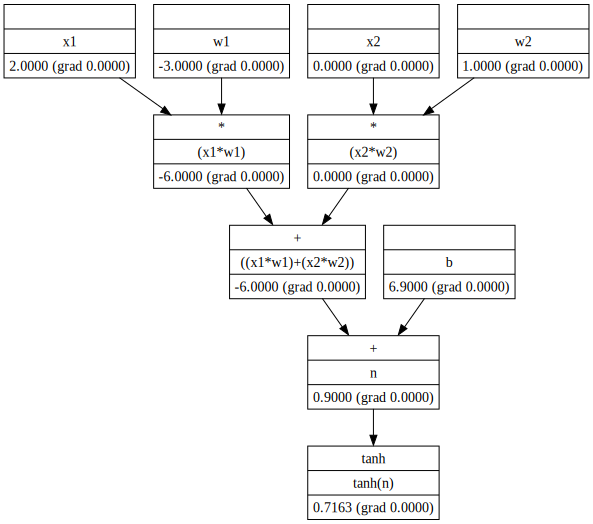

In [198]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.9, label='b')

n = x1*w1 + x2*w2 + b
n.label = 'n'

o = n.tanh()

o.viz()

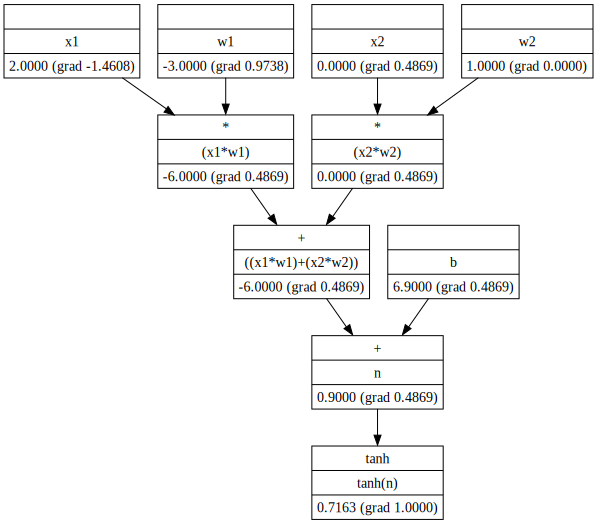

In [199]:
o.backward()
o.viz()